In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch


from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.networks.layers.factories import Act, Norm

from monai.config import print_config
from monai.metrics import DiceMetric
# from src.models.swincspunetr import SwinCSPUNETR
# from src.models.swincspunetr_unet import SwinCSPUNETR_unet
# from src.models.swincspunetr3plus import SwinCSPUNETR3plus

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\.conda\envs\UM\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.17.2
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.

# 모델 설정

In [2]:
from src.dataset.dataset import create_dataloaders, create_dataloaders_bw
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd, RandCropByPosNegLabeld, RandCropd, RandSpatialCrop, RandGaussianSmoothd
)
from monai.transforms import CastToTyped
import numpy as np

augment_list = ['ctfdeconvolved', 'iso', 'isonetcorrected']

augment_num = 0

train_img_dir = "./datasets/aug_data/train/wbp"
train_label_dir = "./datasets/aug_data/train/"
val_img_dir = "./datasets/aug_data/val/wbp"
val_label_dir = "./datasets/aug_data/val/"

train_label_dir = train_label_dir + augment_list[augment_num]
val_label_dir = val_label_dir + augment_list[augment_num]

In [3]:

# DATA CONFIG
img_size =  96 # Match your patch size
img_depth = img_size
n_classes = 1
batch_size = 16 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 1
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 10
# MODEL CONFIG
num_epochs = 4000
lamda = 0.5
ce_weight = 0.4
lr = 0.001
feature_size = 48
use_checkpoint = True
use_v2 = True
drop_rate= 0.2
attn_drop_rate = 0.2
num_bottleneck = 2
# CLASS_WEIGHTS
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치
sigma = 1.5
accumulation_steps = 1
# INIT
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
# )
])
# val_non_random_transforms = Compose([
#     EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
#     NormalizeIntensityd(keys=["image", "label"], nonzero=True, channel_wise=True),
#     Orientationd(keys=["image", "label"], axcodes="RAS"),
# ])
random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandGaussianSmoothd(
    keys=["image"],      # 변환을 적용할 키
    sigma_x = (0.5, sigma), # 각 축(x, y, z)의 시그마 값
    sigma_y = (0.5, sigma),
    sigma_z = (0.5, sigma),
    prob=0.5,
    )  
])
val_random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    # RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    # RandGaussianNoise(prob=0.5, mean=0.0, std=0.1),
])


In [4]:
train_loader, val_loader = None, None
train_loader, val_loader = create_dataloaders_bw(
    train_img_dir, 
    train_label_dir, 
    val_img_dir, 
    val_label_dir, 
    non_random_transforms = non_random_transforms, 
    val_non_random_transforms=non_random_transforms,
    random_transforms = random_transforms, 
    val_random_transforms=val_random_transforms,
    batch_size = loader_batch,
    num_workers=0,
    train_num_repeat=num_repeat,
    val_num_repeat=num_repeat,
    )

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


https://monai.io/model-zoo.html

In [5]:
from monai.losses import TverskyLoss
import torch
import torch.nn as nn

criterion = nn.MSELoss()  # 또는 nn.L1Loss()

In [6]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from pathlib import Path
from monai.networks.nets import UNet
from src.models import UNet_CBAM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=1,
    dropout = drop_rate,
    norm = Norm.INSTANCE,
    act = Act.PRELU 
).to(device)

pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"{augment_list[augment_num]}_UNET_randnoise_{weight_str}_f{feature_size}_d{img_depth}s{img_size}_numb{num_bottleneck}_lr{lr:.0e}_a{lamda:.2f}_b{1-lamda:.2f}_b{batch_size}_r{num_repeat}_ce{ce_weight}_ac{accumulation_steps}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

In [7]:
batch = next(iter(val_loader))
images, labels = batch["image"], batch["label"]
print(images.shape, labels.shape)

torch.Size([1, 1, 96, 96, 96]) torch.Size([1, 1, 96, 96, 96])


In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
import wandb
from datetime import datetime

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = folder_name

# wandb 초기화
wandb.init(
    project='czii',  # 프로젝트 이름 설정
    name=run_name,         # 실행(run) 이름 설정
    config={
        'num_epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'lambda': lamda,
        # "cross_entropy_weight": ce_weight,
        'feature_size': feature_size,
        'img_size': img_size,
        # 'sampling_ratio': ratios_list,
        'device': device.type,
        "checkpoint_dir": str(checkpoint_dir),
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        # "use_checkpoint": use_checkpoint,
        "drop_rate": drop_rate,
        # "attn_drop_rate": attn_drop_rate,
        # "use_v2": use_v2,
        "accumulation_steps": accumulation_steps,
        "num_repeat": num_repeat,
        # "num_bottleneck": num_bottleneck,
        
        # 필요한 하이퍼파라미터 추가
    }
)
# 모델을 wandb에 연결
wandb.watch(model, log='all')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pook0612 (limbw). Use `wandb login --relogin` to force relogin


# 학습

In [10]:
# from monai.metrics import DiceMetric
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
    
def processing(batch_data, model, criterion, device):
    images = batch_data['image'].to(device)  # Input 이미지 (B, 1, 96, 96, 96)
    labels = batch_data['label'].to(device)  # 라벨 (B, 1, 96, 96, 96)
    
    # print("shape:", images.shape, labels.shape)

    labels = labels.float()  # 라벨을 float형으로 변환
    # print("shape:", images.shape, labels.shape)

    # 모델 예측
    outputs = model(images)  # outputs: (B, 1, 96, 96, 96)

    # Loss 계산
    loss = criterion(outputs, labels)
    return loss, outputs, labels

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, accumulation_steps=4):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # 그래디언트 초기화
    with tqdm(train_loader, desc='Training') as pbar:
        for i, batch_data in enumerate(pbar):
            # 손실 계산
            loss, _, _ = processing(batch_data, model, criterion, device)

            # 그래디언트를 계산하고 누적
            loss = loss / accumulation_steps  # 그래디언트 누적을 위한 스케일링
            loss.backward()  # 그래디언트 계산 및 누적
            
            # 그래디언트 업데이트 (accumulation_steps마다 한 번)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()  # 파라미터 업데이트
                optimizer.zero_grad()  # 누적된 그래디언트 초기화
            
            # 손실값 누적 (스케일링 복구)
            epoch_loss += loss.item() * accumulation_steps  # 실제 손실값 반영
            pbar.set_postfix(loss=loss.item() * accumulation_steps)  # 실제 손실값 출력
    avg_loss = epoch_loss / len(train_loader)
    wandb.log({'train_epoch_loss': avg_loss, 'epoch': epoch + 1})
    return avg_loss

# PSNR을 계산하는 함수
def calculate_psnr(pred, target):
    """
    PSNR을 계산하는 함수
    pred: 예측 이미지 (numpy 배열)
    target: 실제 이미지 (numpy 배열)
    """
    pred_np = pred.cpu().numpy()
    target_np = target.cpu().numpy()
    
    # 데이터 범위 확인
    data_range = target_np.max() - target_np.min()
    # print("Data range:", data_range)
    
    # NaN 또는 Inf 값 확인
    # print("NaN in pred:", np.isnan(pred_np).any())
    # print("NaN in target:", np.isnan(target_np).any())
    # print("Inf in pred:", np.isinf(pred_np).any())
    # print("Inf in target:", np.isinf(target_np).any())
    
    # MSE 값 확인
    mse_value = np.mean((target_np - pred_np) ** 2)
    # print("MSE:", mse_value)
    
    psnr_value = psnr(target_np, pred_np, data_range=data_range)
    
    return psnr_value

# 에포크별 검증 함수
def validate_one_epoch(model, val_loader, criterion, device, epoch, calculate_dice_interval):
    model.eval()
    val_loss = 0
    
    psnr_scores = []
    ssim_scores = []
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation') as pbar:
            for batch_data in pbar:
                loss, preds, labels = processing(batch_data, model, criterion, device)
                val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

                # PSNR, SSIM 계산
                if epoch % calculate_dice_interval == 0:
                    psnr_value = calculate_psnr(preds, labels)
                    
                    # PSNR, SSIM 값을 로깅
                    wandb.log({'psnr': psnr_value, 'epoch': epoch + 1})
                    # wandb.log({'ssim': ssim_value, 'epoch': epoch + 1})
                    print(f"PSNR: {psnr_value:.4f},", end=", ")
                    
                    psnr_scores.append(psnr_value)
                    # ssim_scores.append(ssim_value)

    avg_loss = val_loss / len(val_loader)
    # 에포크별 평균 손실 로깅
    wandb.log({'val_epoch_loss': avg_loss, 'epoch': epoch + 1})
    
    if epoch % calculate_dice_interval == 0:
        print("Validation PSNR and SSIM Scores")
        overall_mean_psnr = np.mean(psnr_scores)
        # overall_mean_ssim = np.mean(ssim_scores)
        wandb.log({'overall_mean_psnr': overall_mean_psnr, 'epoch': epoch + 1})
        print(f"\nOverall Mean PSNR: {overall_mean_psnr:.4f}\n")

    # if overall_mean_fbeta is None:
    #     overall_mean_fbeta = 0

    # 시각화 코드
    # 예측과 라벨을 시각화
    
    # preds = preds.cpu().numpy()
    # labels = labels.cpu().numpy()
    # preds = np.squeeze(preds, axis=0)
    # preds = np.squeeze(preds, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # # print(preds.shape, labels.shape)
    
    # slice_idx = 50
    # plt.figure(figsize=(10, 5))

    # # Image 1 비교
    # plt.subplot(1, 2, 1)
    # plt.imshow(preds[slice_idx], cmap="gray")
    # plt.title("Image: Original")
    # plt.axis("off")

    # plt.subplot(1, 2, 2)
    # plt.imshow(labels[slice_idx], cmap="gray")
    # plt.title("Label: denoised")
    # plt.axis("off")
    # plt.show()
    
    return val_loss / len(val_loader), overall_mean_psnr

def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, 
    device, start_epoch, best_val_loss, best_val_fbeta_score=0, calculate_dice_interval=1,
    accumulation_steps=4
):
    """
    모델을 학습하고 검증하는 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 총 학습 epoch 수
        patience: early stopping 기준
        device: GPU/CPU 장치
        start_epoch: 시작 epoch
        best_val_loss: 이전 최적 validation loss
        best_val_fbeta_score: 이전 최적 validation f-beta score
        calculate_dice_interval: Dice 점수 계산 주기
    """
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train One Epoch
        train_loss = train_one_epoch(
            model=model, 
            train_loader=train_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            device=device,
            epoch=epoch,
            accumulation_steps= accumulation_steps
        )
        
        scheduler.step(train_loss)
        # Validate One Epoch
        val_loss, overall_mean_psnr = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=epoch, 
            calculate_dice_interval=calculate_dice_interval
        )

        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation PSNR: {overall_mean_psnr:.4f}")

        if val_loss < best_val_loss and overall_mean_psnr > best_val_fbeta_score:
            best_val_loss = val_loss
            best_val_fbeta_score = overall_mean_psnr
            epochs_no_improve = 0
            checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            print(f"========================================================")
            print(f"SUPER Best model saved. Loss:{best_val_loss:.4f}, Score:{best_val_fbeta_score:.4f}")
            print(f"========================================================")

        # Early stopping 조건 체크
        if val_loss >= best_val_loss and overall_mean_psnr <= best_val_fbeta_score:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        if epochs_no_improve >= patience:
            print("Early stopping")
            checkpoint_path = os.path.join(checkpoint_dir, 'last.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            break
        # if epochs_no_improve%6 == 0 & epochs_no_improve != 0:
        #     # 손실이 개선되지 않았으므로 lambda 감소
        #     new_lamda = max(criterion.lamda - 0.01, 0.35)  # 최소값은 0.1로 설정
        #     criterion.set_lamda(new_lamda)
        #     print(f"Validation loss did not improve. Reducing lambda to {new_lamda:.4f}")

    wandb.finish()


In [11]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=5,
    device=device,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss,
    best_val_fbeta_score=best_val_fbeta_score,
    calculate_dice_interval=1,
    accumulation_steps = accumulation_steps
     ) 

Epoch 1/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 44.27it/s, loss=0.758]

PSNR: 22.2529,, PSNR: 21.7930,, PSNR: 22.3307,, PSNR: 22.8211,, PSNR: 21.7429,, PSNR: 23.4665,, PSNR: 22.6641,, PSNR: 22.0901,, PSNR: 22.5477,, PSNR: 22.8657,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.47it/s, loss=0.758]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 22.4575

Training Loss: 0.9959, Validation Loss: 0.6975, Validation PSNR: 22.4575
SUPER Best model saved. Loss:0.6975, Score:22.4575
Epoch 2/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.59it/s, loss=0.544]

PSNR: 23.9216,, PSNR: 24.1319,, PSNR: 24.0467,, PSNR: 23.9773,, PSNR: 23.8829,, PSNR: 24.4255,, PSNR: 23.8854,, PSNR: 23.7921,, PSNR: 24.5539,, PSNR: 24.0121,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 24.0630

Training Loss: 0.7310, Validation Loss: 0.5185, Validation PSNR: 24.0630


SUPER Best model saved. Loss:0.5185, Score:24.0630
Epoch 3/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 52.13it/s, loss=0.386]


PSNR: 24.5230,, PSNR: 25.0858,, PSNR: 25.3215,, PSNR: 24.7823,, PSNR: 24.3935,, PSNR: 24.4404,, PSNR: 24.7376,, PSNR: 24.8760,, PSNR: 24.9608,, PSNR: 24.0039,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 24.7125

Training Loss: 0.6370, Validation Loss: 0.4117, Validation PSNR: 24.7125
SUPER Best model saved. Loss:0.4117, Score:24.7125
Epoch 4/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.20it/s, loss=0.342]

PSNR: 26.1003,, PSNR: 24.9437,, PSNR: 25.9208,, PSNR: 25.7188,, PSNR: 25.4473,, PSNR: 25.6098,, PSNR: 26.0887,, PSNR: 25.4290,, PSNR: 25.5701,, PSNR: 25.8115,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 25.6640

Training Loss: 0.5624, Validation Loss: 0.3423, Validation PSNR: 25.6640


SUPER Best model saved. Loss:0.3423, Score:25.6640
Epoch 5/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.48it/s, loss=0.313]

PSNR: 24.8518,, PSNR: 26.2560,, PSNR: 26.4020,, PSNR: 26.3780,, PSNR: 26.3851,, PSNR: 26.5942,, PSNR: 25.8351,, PSNR: 26.8920,, PSNR: 26.6285,, PSNR: 26.1980,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.65it/s, loss=0.313]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 26.2421

Training Loss: 0.5187, Validation Loss: 0.3126, Validation PSNR: 26.2421
SUPER Best model saved. Loss:0.3126, Score:26.2421
Epoch 6/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 48.61it/s, loss=0.286]

PSNR: 26.6365,, PSNR: 26.1435,, PSNR: 26.8929,, PSNR: 27.4178,, PSNR: 25.9961,, PSNR: 26.4115,, PSNR: 26.1928,, PSNR: 26.4465,, PSNR: 26.4958,, PSNR: 27.0960,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.02it/s, loss=0.286]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 26.5729

Training Loss: 0.4772, Validation Loss: 0.2895, Validation PSNR: 26.5729
SUPER Best model saved. Loss:0.2895, Score:26.5729
Epoch 7/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.40it/s, loss=0.279]

PSNR: 26.7562,, PSNR: 26.8798,, PSNR: 26.4649,, PSNR: 26.6427,, PSNR: 26.9822,, PSNR: 26.6857,, PSNR: 26.5743,, PSNR: 27.1096,, PSNR: 27.1214,, PSNR: 26.6531,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 26.7870

Training Loss: 0.4299, Validation Loss: 0.2714, Validation PSNR: 26.7870


SUPER Best model saved. Loss:0.2714, Score:26.7870
Epoch 8/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.17it/s, loss=0.263]

PSNR: 27.2433,, PSNR: 26.8455,, PSNR: 27.2879,, PSNR: 27.5850,, PSNR: 27.5894,, PSNR: 26.8205,, PSNR: 27.4228,, PSNR: 26.7252,, PSNR: 26.7235,, PSNR: 27.2882,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.15it/s, loss=0.263]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.1531

Training Loss: 0.4503, Validation Loss: 0.2679, Validation PSNR: 27.1531
SUPER Best model saved. Loss:0.2679, Score:27.1531
Epoch 9/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.04it/s, loss=0.282]

PSNR: 27.7940,, PSNR: 26.5545,, PSNR: 27.6692,, PSNR: 27.0912,, PSNR: 26.7665,, PSNR: 27.0366,, PSNR: 26.5634,, PSNR: 26.1897,, PSNR: 26.5687,, PSNR: 27.6863,, Validation PSNR and SSIM Scores



Overall Mean PSNR: 26.9920

Training Loss: 0.4146, Validation Loss: 0.2641, Validation PSNR: 26.9920
Epoch 10/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 39.97it/s, loss=0.249]

PSNR: 26.3033,, PSNR: 27.2551,, PSNR: 27.2391,, PSNR: 27.5120,, PSNR: 28.0044,, PSNR: 26.7664,, PSNR: 27.0571,, PSNR: 26.5308,, PSNR: 26.9327,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 41.25it/s, loss=0.249]


PSNR: 27.1455,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.0746

Training Loss: 0.4144, Validation Loss: 0.2544, Validation PSNR: 27.0746
Epoch 11/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 47.88it/s, loss=0.239]

PSNR: 26.7770,, PSNR: 26.5141,, PSNR: 27.9310,, PSNR: 27.2399,, PSNR: 27.3105,, PSNR: 26.6047,, PSNR: 26.8594,, PSNR: 26.1126,, PSNR: 26.9390,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.96it/s, loss=0.239]


PSNR: 26.5870,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 26.8875

Training Loss: 0.4138, Validation Loss: 0.2464, Validation PSNR: 26.8875
Epoch 12/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 47.08it/s, loss=0.245]

PSNR: 27.5584,, PSNR: 27.2263,, PSNR: 27.0045,, PSNR: 28.0357,, PSNR: 27.5757,, PSNR: 27.2429,, PSNR: 27.3363,, PSNR: 26.3802,, PSNR: 26.8005,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 44.54it/s, loss=0.243]


PSNR: 26.4582,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.1619

Training Loss: 0.3978, Validation Loss: 0.2476, Validation PSNR: 27.1619
SUPER Best model saved. Loss:0.2476, Score:27.1619
Epoch 13/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 54.71it/s, loss=0.235]

PSNR: 27.0248,, PSNR: 27.5031,, PSNR: 27.7865,, PSNR: 27.2662,, PSNR: 27.1814,, PSNR: 27.1655,, PSNR: 26.5412,, PSNR: 27.1369,, PSNR: 27.4686,, PSNR: 27.4819,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.2556

Training Loss: 0.3919, Validation Loss: 0.2423, Validation PSNR: 27.2556


SUPER Best model saved. Loss:0.2423, Score:27.2556
Epoch 14/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 52.44it/s, loss=0.235]


PSNR: 27.0112,, PSNR: 27.4301,, PSNR: 27.3432,, PSNR: 26.9899,, PSNR: 26.8059,, PSNR: 28.0956,, PSNR: 27.0319,, PSNR: 26.1382,, PSNR: 26.4328,, PSNR: 27.5702,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.0849

Training Loss: 0.3842, Validation Loss: 0.2414, Validation PSNR: 27.0849
Epoch 15/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 47.63it/s, loss=0.232]

PSNR: 28.1792,, PSNR: 27.3594,, PSNR: 27.6117,, PSNR: 26.8835,, PSNR: 26.8110,, PSNR: 27.1022,, PSNR: 27.0676,, PSNR: 27.6354,, PSNR: 27.0988,, PSNR: 27.5343,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.81it/s, loss=0.232]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3283

Training Loss: 0.3876, Validation Loss: 0.2427, Validation PSNR: 27.3283
Epoch 16/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.92it/s, loss=0.23]

PSNR: 26.8852,, PSNR: 27.5142,, PSNR: 27.8123,, PSNR: 28.1562,, PSNR: 27.5239,, PSNR: 26.9592,, PSNR: 26.9618,, PSNR: 27.2849,, PSNR: 27.7575,, PSNR: 27.2130,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4068

Training Loss: 0.3746, Validation Loss: 0.2343, Validation PSNR: 27.4068


SUPER Best model saved. Loss:0.2343, Score:27.4068
Epoch 17/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 52.76it/s, loss=0.235]


PSNR: 27.4206,, PSNR: 27.5291,, PSNR: 26.8873,, PSNR: 27.3135,, PSNR: 27.4763,, PSNR: 27.0456,, PSNR: 27.4972,, PSNR: 27.3670,, PSNR: 27.2126,, PSNR: 27.2669,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3016

Training Loss: 0.3916, Validation Loss: 0.2328, Validation PSNR: 27.3016
Epoch 18/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.68it/s, loss=0.217]

PSNR: 27.4467,, PSNR: 27.7118,, PSNR: 27.0940,, PSNR: 27.2561,, PSNR: 27.1023,, PSNR: 27.6512,, PSNR: 26.9354,, PSNR: 26.3284,, PSNR: 27.1987,, PSNR: 27.2458,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.79it/s, loss=0.217]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.1970

Training Loss: 0.3740, Validation Loss: 0.2286, Validation PSNR: 27.1970
Epoch 19/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.16it/s, loss=0.23]


PSNR: 27.2699,, PSNR: 26.8510,, PSNR: 27.7364,, PSNR: 27.4771,, PSNR: 27.3676,, PSNR: 26.7506,, PSNR: 28.2402,, PSNR: 28.2277,, PSNR: 27.5055,, PSNR: 26.9904,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4416

Training Loss: 0.3703, Validation Loss: 0.2356, Validation PSNR: 27.4416
Epoch 20/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 52.27it/s, loss=0.242]

PSNR: 27.1321,, PSNR: 27.8732,, PSNR: 26.9298,, PSNR: 27.0969,, PSNR: 27.7880,, PSNR: 27.0245,, PSNR: 27.2550,, PSNR: 27.2179,, PSNR: 27.1956,, PSNR: 27.5680,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 50.81it/s, loss=0.242]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3081

Training Loss: 0.3609, Validation Loss: 0.2281, Validation PSNR: 27.3081
Epoch 21/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.27it/s, loss=0.226]


PSNR: 27.6574,, PSNR: 26.9205,, PSNR: 27.1870,, PSNR: 28.2537,, PSNR: 27.1036,, PSNR: 27.6298,, PSNR: 26.4867,, PSNR: 27.1127,, PSNR: 26.5354,, PSNR: 26.3263,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.1213

Training Loss: 0.3876, Validation Loss: 0.2308, Validation PSNR: 27.1213
Epoch 22/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.80it/s, loss=0.217]

PSNR: 27.1884,, PSNR: 27.6635,, PSNR: 27.3491,, PSNR: 28.1735,, PSNR: 27.3501,, PSNR: 28.2144,, PSNR: 27.9076,, PSNR: 27.6423,, PSNR: 27.2738,, PSNR: 27.2913,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 51.15it/s, loss=0.217]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6054

Training Loss: 0.3695, Validation Loss: 0.2302, Validation PSNR: 27.6054
SUPER Best model saved. Loss:0.2302, Score:27.6054
Epoch 23/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.50it/s, loss=0.227]


PSNR: 27.2682,, PSNR: 27.4001,, PSNR: 27.4225,, PSNR: 26.6750,, PSNR: 27.7139,, PSNR: 27.2829,, PSNR: 27.3377,, PSNR: 26.7825,, PSNR: 27.7115,, PSNR: 26.6179,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.2212

Training Loss: 0.3756, Validation Loss: 0.2307, Validation PSNR: 27.2212
Epoch 24/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.91it/s, loss=0.234]

PSNR: 28.3761,, PSNR: 26.8295,, PSNR: 27.2506,, PSNR: 28.9338,, PSNR: 27.2129,, PSNR: 27.3302,, PSNR: 26.9653,, PSNR: 28.3590,, PSNR: 27.5083,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.25it/s, loss=0.234]


PSNR: 27.1013,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5867

Training Loss: 0.3713, Validation Loss: 0.2286, Validation PSNR: 27.5867
Epoch 25/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 53.28it/s, loss=0.222]


PSNR: 27.4888,, PSNR: 27.1074,, PSNR: 27.2551,, PSNR: 27.2123,, PSNR: 27.5538,, PSNR: 26.7805,, PSNR: 28.0234,, PSNR: 27.1600,, PSNR: 27.3525,, PSNR: 27.6360,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3570

Training Loss: 0.3710, Validation Loss: 0.2332, Validation PSNR: 27.3570
Epoch 26/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.42it/s, loss=0.226]


PSNR: 26.9629,, PSNR: 27.0207,, PSNR: 27.1084,, PSNR: 26.7222,, PSNR: 28.1614,, PSNR: 27.3052,, PSNR: 27.5569,, PSNR: 27.3581,, PSNR: 27.6339,, PSNR: 26.8194,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.2649

Training Loss: 0.3636, Validation Loss: 0.2302, Validation PSNR: 27.2649
Epoch 27/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 53.14it/s, loss=0.215]


PSNR: 27.3028,, PSNR: 27.8754,, PSNR: 27.3484,, PSNR: 27.4692,, PSNR: 28.0546,, PSNR: 27.7306,, PSNR: 26.3609,, PSNR: 26.6847,, PSNR: 27.5078,, PSNR: 27.2292,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3564

Training Loss: 0.3457, Validation Loss: 0.2214, Validation PSNR: 27.3564
Epoch 28/4000


Validation:  40%|████      | 4/10 [00:00<00:00, 35.08it/s, loss=0.228]

PSNR: 27.3600,, PSNR: 26.8008,, PSNR: 27.2691,, PSNR: 28.2112,, PSNR: 27.4481,, PSNR: 27.0208,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 24.50it/s, loss=0.244]


PSNR: 27.3849,, PSNR: 27.7886,, PSNR: 26.9708,, PSNR: 26.5323,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.2787

Training Loss: 0.3608, Validation Loss: 0.2230, Validation PSNR: 27.2787
Epoch 29/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 45.16it/s, loss=0.226]

PSNR: 27.1460,, PSNR: 28.3420,, PSNR: 27.7747,, PSNR: 27.2041,, PSNR: 27.2103,, PSNR: 27.5450,, PSNR: 27.3956,, PSNR: 27.1004,, PSNR: 27.1207,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 44.07it/s, loss=0.226]


PSNR: 27.5579,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4397

Training Loss: 0.3650, Validation Loss: 0.2282, Validation PSNR: 27.4397
Epoch 30/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.09it/s, loss=0.214]

PSNR: 27.5009,, PSNR: 27.9867,, PSNR: 28.6342,, PSNR: 28.4166,, PSNR: 27.4920,, PSNR: 27.1729,, PSNR: 27.7868,, PSNR: 26.9882,, PSNR: 27.9049,, PSNR: 27.6733,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.51it/s, loss=0.214]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7556

Training Loss: 0.3616, Validation Loss: 0.2184, Validation PSNR: 27.7556
SUPER Best model saved. Loss:0.2184, Score:27.7556
Epoch 31/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 54.39it/s, loss=0.24]


PSNR: 26.6644,, PSNR: 27.3869,, PSNR: 26.8017,, PSNR: 27.9760,, PSNR: 26.6226,, PSNR: 28.2976,, PSNR: 27.4823,, PSNR: 27.6291,, PSNR: 27.4953,, PSNR: 27.6431,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3999

Training Loss: 0.3676, Validation Loss: 0.2293, Validation PSNR: 27.3999
Epoch 32/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.40it/s, loss=0.224]


PSNR: 27.7697,, PSNR: 28.2571,, PSNR: 27.4039,, PSNR: 27.4416,, PSNR: 26.7500,, PSNR: 28.9862,, PSNR: 27.7209,, PSNR: 26.7100,, PSNR: 27.3327,, PSNR: 28.0779,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6450

Training Loss: 0.3548, Validation Loss: 0.2230, Validation PSNR: 27.6450
Epoch 33/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 49.24it/s, loss=0.237]

PSNR: 27.1397,, PSNR: 27.3390,, PSNR: 27.5034,, PSNR: 27.3031,, PSNR: 27.1164,, PSNR: 28.0221,, PSNR: 28.4812,, PSNR: 27.5602,, PSNR: 27.5818,, PSNR: 27.7069,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.88it/s, loss=0.237]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5754

Training Loss: 0.3676, Validation Loss: 0.2332, Validation PSNR: 27.5754
Epoch 34/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 44.17it/s, loss=0.22] 

PSNR: 28.1684,, PSNR: 27.4106,, PSNR: 26.5817,, PSNR: 27.3605,, PSNR: 27.8366,, PSNR: 27.3300,, PSNR: 27.6571,, PSNR: 27.6468,, PSNR: 27.9042,, PSNR: 28.3964,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 46.71it/s, loss=0.22]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6292

Training Loss: 0.3449, Validation Loss: 0.2162, Validation PSNR: 27.6292
Epoch 35/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 53.44it/s, loss=0.203]


PSNR: 27.3098,, PSNR: 27.4014,, PSNR: 27.7655,, PSNR: 27.7563,, PSNR: 27.1636,, PSNR: 27.9275,, PSNR: 27.5037,, PSNR: 27.2415,, PSNR: 27.6330,, PSNR: 27.3786,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5081

Training Loss: 0.3353, Validation Loss: 0.2163, Validation PSNR: 27.5081
Epoch 36/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 45.29it/s, loss=0.226]

PSNR: 27.8364,, PSNR: 27.5472,, PSNR: 27.8461,, PSNR: 28.2559,, PSNR: 28.2775,, PSNR: 27.8717,, PSNR: 27.5695,, PSNR: 27.0965,, PSNR: 26.8989,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.10it/s, loss=0.226]


PSNR: 27.9542,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7154

Training Loss: 0.3601, Validation Loss: 0.2231, Validation PSNR: 27.7154
Epoch 37/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 43.39it/s, loss=0.227]

PSNR: 29.1677,, PSNR: 28.5803,, PSNR: 27.8233,, PSNR: 28.1299,, PSNR: 28.4539,, PSNR: 27.3551,, PSNR: 26.9330,, PSNR: 28.2001,, PSNR: 28.1401,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.23it/s, loss=0.211]


PSNR: 27.4096,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 28.0193

Training Loss: 0.3576, Validation Loss: 0.2184, Validation PSNR: 28.0193
SUPER Best model saved. Loss:0.2184, Score:28.0193
Epoch 38/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.18it/s, loss=0.21]


PSNR: 27.7288,, PSNR: 26.9985,, PSNR: 27.0811,, PSNR: 28.0397,, PSNR: 28.2264,, PSNR: 26.9540,, PSNR: 27.7139,, PSNR: 27.4347,, PSNR: 27.8017,, PSNR: 27.2922,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5271

Training Loss: 0.3602, Validation Loss: 0.2167, Validation PSNR: 27.5271
Epoch 39/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.30it/s, loss=0.288]


PSNR: 27.7492,, PSNR: 28.3802,, PSNR: 27.8597,, PSNR: 27.9444,, PSNR: 27.4885,, PSNR: 26.7419,, PSNR: 26.8782,, PSNR: 27.0355,, PSNR: 27.8197,, PSNR: 26.1511,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4048

Training Loss: 0.3482, Validation Loss: 0.2205, Validation PSNR: 27.4048
Epoch 40/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 54.71it/s, loss=0.209]


PSNR: 27.8072,, PSNR: 28.1949,, PSNR: 27.1050,, PSNR: 28.4646,, PSNR: 28.6489,, PSNR: 27.0676,, PSNR: 27.7669,, PSNR: 27.6307,, PSNR: 28.6658,, PSNR: 27.2973,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.8649

Training Loss: 0.3500, Validation Loss: 0.2196, Validation PSNR: 27.8649
Epoch 41/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.79it/s, loss=0.218]


PSNR: 28.0097,, PSNR: 27.6427,, PSNR: 28.1688,, PSNR: 27.7016,, PSNR: 27.9338,, PSNR: 27.4278,, PSNR: 28.1580,, PSNR: 26.8656,, PSNR: 27.9278,, PSNR: 27.7290,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7565

Training Loss: 0.3587, Validation Loss: 0.2174, Validation PSNR: 27.7565
Epoch 42/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 53.31it/s, loss=0.246]


PSNR: 27.6807,, PSNR: 27.5797,, PSNR: 27.0521,, PSNR: 26.8460,, PSNR: 27.1275,, PSNR: 27.6668,, PSNR: 28.1244,, PSNR: 26.9026,, PSNR: 27.3329,, PSNR: 27.3255,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3638

Training Loss: 0.3367, Validation Loss: 0.2176, Validation PSNR: 27.3638
Epoch 43/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 54.37it/s, loss=0.208]


PSNR: 25.9895,, PSNR: 28.0217,, PSNR: 28.1171,, PSNR: 28.0211,, PSNR: 28.8489,, PSNR: 27.7453,, PSNR: 28.5781,, PSNR: 27.0363,, PSNR: 27.7388,, PSNR: 28.5656,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.8662

Training Loss: 0.3483, Validation Loss: 0.2251, Validation PSNR: 27.8662
Epoch 44/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 53.53it/s, loss=0.234]


PSNR: 27.6077,, PSNR: 27.4273,, PSNR: 27.3525,, PSNR: 28.7512,, PSNR: 28.3674,, PSNR: 28.5538,, PSNR: 27.5594,, PSNR: 27.4917,, PSNR: 28.4327,, PSNR: 27.3660,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.8910

Training Loss: 0.3696, Validation Loss: 0.2231, Validation PSNR: 27.8910
Epoch 45/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 54.12it/s, loss=0.216]


PSNR: 27.6157,, PSNR: 28.0614,, PSNR: 27.6668,, PSNR: 27.4191,, PSNR: 26.2907,, PSNR: 27.1868,, PSNR: 27.4220,, PSNR: 27.4817,, PSNR: 26.7644,, PSNR: 28.4414,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4350

Training Loss: 0.3624, Validation Loss: 0.2248, Validation PSNR: 27.4350
Epoch 46/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 48.44it/s, loss=0.216]

PSNR: 27.8546,, PSNR: 27.4689,, PSNR: 27.9391,, PSNR: 27.1997,, PSNR: 27.3526,, PSNR: 26.8566,, PSNR: 27.3943,, PSNR: 28.4589,, PSNR: 27.3885,, PSNR: 28.4867,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.82it/s, loss=0.216]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6400

Training Loss: 0.3661, Validation Loss: 0.2193, Validation PSNR: 27.6400
Epoch 47/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 52.27it/s, loss=0.215]

PSNR: 27.7360,, PSNR: 27.4003,, PSNR: 27.9451,, PSNR: 27.2206,, PSNR: 28.2744,, PSNR: 27.8639,, PSNR: 27.3536,, PSNR: 27.6731,, PSNR: 27.3649,, PSNR: 27.8334,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 51.01it/s, loss=0.215]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6665

Training Loss: 0.3486, Validation Loss: 0.2181, Validation PSNR: 27.6665
Epoch 48/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 53.47it/s, loss=0.211]


PSNR: 27.1504,, PSNR: 27.3278,, PSNR: 27.7701,, PSNR: 27.2993,, PSNR: 27.4802,, PSNR: 28.4552,, PSNR: 26.4316,, PSNR: 27.6964,, PSNR: 27.0940,, PSNR: 26.7735,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3478

Training Loss: 0.3546, Validation Loss: 0.2244, Validation PSNR: 27.3478
Epoch 49/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.35it/s, loss=0.244]


PSNR: 26.9688,, PSNR: 28.1650,, PSNR: 27.3508,, PSNR: 27.6292,, PSNR: 28.0056,, PSNR: 27.9168,, PSNR: 27.1998,, PSNR: 27.5304,, PSNR: 27.3651,, PSNR: 27.4109,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5542

Training Loss: 0.3454, Validation Loss: 0.2245, Validation PSNR: 27.5542
Epoch 50/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.56it/s, loss=0.224]

PSNR: 26.9163,, PSNR: 27.2359,, PSNR: 27.5379,, PSNR: 25.4377,, PSNR: 27.8798,, PSNR: 27.1213,, PSNR: 27.5121,, PSNR: 28.0906,, PSNR: 27.0683,, PSNR: 28.5595,, 

Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3359

Training Loss: 0.3529, Validation Loss: 0.2232, Validation PSNR: 27.3359
Epoch 51/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 52.61it/s, loss=0.204]


PSNR: 27.8917,, PSNR: 27.9514,, PSNR: 27.5720,, PSNR: 28.1676,, PSNR: 27.0141,, PSNR: 27.6132,, PSNR: 27.4946,, PSNR: 27.7543,, PSNR: 28.5006,, PSNR: 27.5896,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7549

Training Loss: 0.3313, Validation Loss: 0.2201, Validation PSNR: 27.7549
Epoch 52/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.54it/s, loss=0.216]

PSNR: 27.6780,, PSNR: 27.6529,, PSNR: 27.7052,, PSNR: 29.0846,, PSNR: 27.3874,, PSNR: 26.7641,, PSNR: 27.9268,, PSNR: 27.4324,, PSNR: 28.1865,, PSNR: 26.9125,, 

Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6730

Training Loss: 0.3454, Validation Loss: 0.2161, Validation PSNR: 27.6730
Epoch 53/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.24it/s, loss=0.221]


PSNR: 27.8034,, PSNR: 27.2206,, PSNR: 27.5744,, PSNR: 27.1850,, PSNR: 26.6795,, PSNR: 27.2234,, PSNR: 27.5513,, PSNR: 27.2984,, PSNR: 27.5333,, PSNR: 27.4849,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3554

Training Loss: 0.3747, Validation Loss: 0.2202, Validation PSNR: 27.3554
Epoch 54/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 51.39it/s, loss=0.216]

PSNR: 27.2562,, PSNR: 27.4936,, PSNR: 27.5107,, PSNR: 28.4521,, PSNR: 27.2312,, PSNR: 28.0345,, PSNR: 27.1843,, PSNR: 28.0601,, PSNR: 26.6783,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 46.56it/s, loss=0.216]


PSNR: 28.3947,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6296

Training Loss: 0.3477, Validation Loss: 0.2126, Validation PSNR: 27.6296
Epoch 55/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 51.63it/s, loss=0.228]


PSNR: 27.8151,, PSNR: 27.2772,, PSNR: 27.4618,, PSNR: 28.2078,, PSNR: 27.9760,, PSNR: 27.4438,, PSNR: 28.4167,, PSNR: 28.4972,, PSNR: 27.0308,, PSNR: 28.4858,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.8612

Training Loss: 0.3580, Validation Loss: 0.2157, Validation PSNR: 27.8612
Epoch 56/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 49.31it/s, loss=0.212]

PSNR: 27.7408,, PSNR: 26.4813,, PSNR: 28.0249,, PSNR: 27.6148,, PSNR: 27.4246,, PSNR: 27.1811,, PSNR: 27.8443,, PSNR: 28.3355,, PSNR: 26.8427,, PSNR: 28.5721,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.74it/s, loss=0.212]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6062

Training Loss: 0.3340, Validation Loss: 0.2181, Validation PSNR: 27.6062
Epoch 57/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.10it/s, loss=0.222]

PSNR: 27.6556,, PSNR: 27.9274,, PSNR: 27.7438,, PSNR: 27.9664,, PSNR: 27.8417,, PSNR: 27.7654,, PSNR: 27.9203,, PSNR: 28.5903,, PSNR: 27.9960,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.94it/s, loss=0.222]


PSNR: 28.6046,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 28.0011

Training Loss: 0.3595, Validation Loss: 0.2155, Validation PSNR: 28.0011
Epoch 58/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 49.95it/s, loss=0.204]

PSNR: 27.5568,, PSNR: 27.5843,, PSNR: 27.5428,, PSNR: 27.9547,, PSNR: 27.4152,, PSNR: 26.8801,, PSNR: 26.9544,, PSNR: 26.6011,, PSNR: 27.2456,, PSNR: 27.9994,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 50.54it/s, loss=0.204]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.3734

Training Loss: 0.3587, Validation Loss: 0.2152, Validation PSNR: 27.3734
Epoch 59/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.45it/s, loss=0.23]


PSNR: 27.3120,, PSNR: 27.9966,, PSNR: 26.8508,, PSNR: 27.8895,, PSNR: 27.6027,, PSNR: 27.4418,, PSNR: 28.3001,, PSNR: 27.8210,, PSNR: 27.3952,, PSNR: 27.9227,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6532

Training Loss: 0.3672, Validation Loss: 0.2159, Validation PSNR: 27.6532
Epoch 60/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.29it/s, loss=0.232]


PSNR: 27.7346,, PSNR: 28.0475,, PSNR: 27.5414,, PSNR: 27.5513,, PSNR: 27.2742,, PSNR: 26.7524,, PSNR: 27.7075,, PSNR: 26.5211,, PSNR: 27.9715,, PSNR: 27.3549,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4457

Training Loss: 0.3635, Validation Loss: 0.2210, Validation PSNR: 27.4457
Epoch 61/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 49.94it/s, loss=0.22] 

PSNR: 27.5614,, PSNR: 26.4084,, PSNR: 26.8075,, PSNR: 28.2811,, PSNR: 26.5322,, PSNR: 27.4714,, PSNR: 27.5619,, PSNR: 27.5243,, PSNR: 28.6066,, PSNR: 27.4465,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 50.05it/s, loss=0.22]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4201

Training Loss: 0.3637, Validation Loss: 0.2202, Validation PSNR: 27.4201
Epoch 62/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 46.29it/s, loss=0.219]

PSNR: 29.1209,, PSNR: 28.4172,, PSNR: 27.4398,, PSNR: 26.9455,, PSNR: 27.7305,, PSNR: 27.7417,, PSNR: 27.6195,, PSNR: 28.5160,, PSNR: 26.5044,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 46.37it/s, loss=0.242]


PSNR: 26.5730,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6609

Training Loss: 0.3471, Validation Loss: 0.2227, Validation PSNR: 27.6609
Epoch 63/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.09it/s, loss=0.213]

PSNR: 27.2960,, PSNR: 26.4079,, PSNR: 26.8622,, PSNR: 27.1777,, PSNR: 27.7412,, PSNR: 26.9959,, PSNR: 26.9918,, PSNR: 26.5079,, PSNR: 27.3287,, PSNR: 27.8265,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 50.31it/s, loss=0.213]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.1136

Training Loss: 0.3629, Validation Loss: 0.2240, Validation PSNR: 27.1136
Epoch 64/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.76it/s, loss=0.207]


PSNR: 26.8300,, PSNR: 27.9626,, PSNR: 29.1237,, PSNR: 27.6702,, PSNR: 26.9850,, PSNR: 27.6749,, PSNR: 27.7785,, PSNR: 27.6895,, PSNR: 27.6161,, PSNR: 28.6563,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7987

Training Loss: 0.3619, Validation Loss: 0.2150, Validation PSNR: 27.7987
Epoch 65/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.23it/s, loss=0.22]

PSNR: 28.1251,, PSNR: 27.9734,, PSNR: 27.2866,, PSNR: 28.6954,, PSNR: 27.1303,, PSNR: 28.4312,, PSNR: 27.6141,, PSNR: 26.2955,, PSNR: 26.9666,, PSNR: 27.6887,, 

Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6207

Training Loss: 0.3713, Validation Loss: 0.2251, Validation PSNR: 27.6207
Epoch 66/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 45.42it/s, loss=0.209]

PSNR: 27.6247,, PSNR: 27.2718,, PSNR: 27.5395,, PSNR: 28.4302,, PSNR: 27.3153,, PSNR: 27.9267,, PSNR: 26.3694,, PSNR: 27.7992,, PSNR: 28.2658,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 46.35it/s, loss=0.209]


PSNR: 29.2159,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7758

Training Loss: 0.3454, Validation Loss: 0.2179, Validation PSNR: 27.7758
Epoch 67/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.06it/s, loss=0.208]

PSNR: 27.7330,, PSNR: 26.0715,, PSNR: 27.5346,, PSNR: 28.5179,, PSNR: 28.2402,, PSNR: 26.8802,, PSNR: 27.2500,, PSNR: 27.5066,, PSNR: 27.5861,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.94it/s, loss=0.208]


PSNR: 27.4723,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4792

Training Loss: 0.3571, Validation Loss: 0.2291, Validation PSNR: 27.4792
Epoch 68/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.37it/s, loss=0.213]


PSNR: 26.4144,, PSNR: 27.4632,, PSNR: 28.2027,, PSNR: 27.6103,, PSNR: 28.1436,, PSNR: 27.3932,, PSNR: 27.2653,, PSNR: 28.6091,, PSNR: 27.6461,, PSNR: 27.7308,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6479

Training Loss: 0.3540, Validation Loss: 0.2186, Validation PSNR: 27.6479
Epoch 69/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 49.44it/s, loss=0.21] 

PSNR: 27.9803,, PSNR: 27.4501,, PSNR: 27.8609,, PSNR: 27.5587,, PSNR: 26.9203,, PSNR: 28.4008,, PSNR: 27.6680,, PSNR: 28.4803,, PSNR: 27.2909,, PSNR: 27.4687,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.12it/s, loss=0.21]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7079

Training Loss: 0.3647, Validation Loss: 0.2172, Validation PSNR: 27.7079
Epoch 70/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 50.30it/s, loss=0.212]


PSNR: 27.7381,, PSNR: 27.5019,, PSNR: 27.5475,, PSNR: 27.4057,, PSNR: 27.1549,, PSNR: 28.1790,, PSNR: 27.0908,, PSNR: 27.5290,, PSNR: 27.3385,, PSNR: 27.8423,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5328

Training Loss: 0.3560, Validation Loss: 0.2159, Validation PSNR: 27.5328
Epoch 71/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.54it/s, loss=0.21] 

PSNR: 28.0440,, PSNR: 27.7075,, PSNR: 27.9680,, PSNR: 27.9826,, PSNR: 27.0898,, PSNR: 27.9180,, PSNR: 27.3689,, PSNR: 27.6711,, PSNR: 27.8483,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.43it/s, loss=0.21]


PSNR: 27.9270,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7525

Training Loss: 0.3350, Validation Loss: 0.2181, Validation PSNR: 27.7525
Epoch 72/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.30it/s, loss=0.227]

PSNR: 27.4062,, PSNR: 27.6056,, PSNR: 27.2590,, PSNR: 27.7500,, PSNR: 27.5437,, PSNR: 27.9871,, PSNR: 27.4356,, PSNR: 28.4186,, PSNR: 27.9977,, PSNR: 27.8831,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.47it/s, loss=0.227]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7287

Training Loss: 0.3436, Validation Loss: 0.2215, Validation PSNR: 27.7287
Epoch 73/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 49.76it/s, loss=0.212]

PSNR: 27.3431,, PSNR: 27.4970,, PSNR: 27.7273,, PSNR: 27.4075,, PSNR: 27.6127,, PSNR: 27.4239,, PSNR: 27.7760,, PSNR: 27.7646,, PSNR: 27.7500,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.76it/s, loss=0.212]


PSNR: 27.4828,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5785

Training Loss: 0.3536, Validation Loss: 0.2158, Validation PSNR: 27.5785
Epoch 74/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.27it/s, loss=0.225]

PSNR: 27.7287,, PSNR: 27.9890,, PSNR: 27.8332,, PSNR: 27.5606,, PSNR: 27.8944,, PSNR: 26.4176,, PSNR: 27.3081,, PSNR: 28.3264,, PSNR: 28.0962,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.74it/s, loss=0.225]


PSNR: 27.9328,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7087

Training Loss: 0.3489, Validation Loss: 0.2182, Validation PSNR: 27.7087
Epoch 75/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.67it/s, loss=0.227]

PSNR: 26.9076,, PSNR: 28.0742,, PSNR: 28.1828,, PSNR: 27.4297,, PSNR: 27.6309,, PSNR: 27.7836,, PSNR: 27.9016,, PSNR: 27.8261,, PSNR: 27.2496,, PSNR: 27.8902,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.60it/s, loss=0.227]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6876

Training Loss: 0.3593, Validation Loss: 0.2164, Validation PSNR: 27.6876
Epoch 76/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 45.13it/s, loss=0.214]

PSNR: 27.6687,, PSNR: 27.5363,, PSNR: 25.8461,, PSNR: 27.8874,, PSNR: 27.4614,, PSNR: 27.7298,, PSNR: 27.5177,, PSNR: 27.4343,, PSNR: 27.5355,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 46.68it/s, loss=0.214]


PSNR: 28.6334,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5251

Training Loss: 0.3403, Validation Loss: 0.2207, Validation PSNR: 27.5251
Epoch 77/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 46.93it/s, loss=0.216]

PSNR: 27.3900,, PSNR: 27.5152,, PSNR: 28.0061,, PSNR: 26.9362,, PSNR: 27.8166,, PSNR: 26.9598,, PSNR: 27.2592,, PSNR: 28.4614,, PSNR: 27.4387,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 46.78it/s, loss=0.211]


PSNR: 27.8110,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5594

Training Loss: 0.3592, Validation Loss: 0.2173, Validation PSNR: 27.5594
Epoch 78/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 49.58it/s, loss=0.206]

PSNR: 29.1642,, PSNR: 27.6249,, PSNR: 27.9742,, PSNR: 27.4495,, PSNR: 27.7202,, PSNR: 27.7020,, PSNR: 27.4118,, PSNR: 26.7011,, PSNR: 28.0227,, PSNR: 27.1353,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.30it/s, loss=0.206]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6906

Training Loss: 0.3378, Validation Loss: 0.2116, Validation PSNR: 27.6906
Epoch 79/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 49.58it/s, loss=0.218]


PSNR: 27.5256,, PSNR: 27.9363,, PSNR: 27.2568,, PSNR: 26.8237,, PSNR: 26.8290,, PSNR: 27.5627,, PSNR: 28.2566,, PSNR: 27.8623,, PSNR: 27.3962,, PSNR: 27.7597,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5209

Training Loss: 0.3512, Validation Loss: 0.2202, Validation PSNR: 27.5209
Epoch 80/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 49.98it/s, loss=0.209]

PSNR: 27.0347,, PSNR: 27.4779,, PSNR: 27.8098,, PSNR: 28.5175,, PSNR: 28.2679,, PSNR: 27.6614,, PSNR: 27.9697,, PSNR: 28.0367,, PSNR: 28.0979,, PSNR: 26.7753,, 

Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7649

Training Loss: 0.3511, Validation Loss: 0.2163, Validation PSNR: 27.7649
Epoch 81/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.36it/s, loss=0.224]

PSNR: 28.1477,, PSNR: 27.3838,, PSNR: 27.6524,, PSNR: 26.7961,, PSNR: 27.5259,, PSNR: 26.7049,, PSNR: 27.4970,, PSNR: 27.9099,, PSNR: 27.5602,, PSNR: 27.6028,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.45it/s, loss=0.224]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4781

Training Loss: 0.3490, Validation Loss: 0.2226, Validation PSNR: 27.4781
Epoch 82/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.84it/s, loss=0.211]

PSNR: 27.4685,, PSNR: 27.8669,, PSNR: 27.4351,, PSNR: 27.7989,, PSNR: 28.0938,, PSNR: 27.5496,, PSNR: 28.0267,, PSNR: 28.4221,, PSNR: 27.8416,, PSNR: 27.7722,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.66it/s, loss=0.211]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.8275

Training Loss: 0.3489, Validation Loss: 0.2180, Validation PSNR: 27.8275
Epoch 83/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 49.21it/s, loss=0.238]

PSNR: 27.7717,, PSNR: 26.7652,, PSNR: 27.8212,, PSNR: 26.4265,, PSNR: 26.9897,, PSNR: 28.5616,, PSNR: 27.6608,, PSNR: 28.1840,, PSNR: 27.2877,, PSNR: 26.7019,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.72it/s, loss=0.238]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.4170

Training Loss: 0.3597, Validation Loss: 0.2159, Validation PSNR: 27.4170
Epoch 84/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 47.23it/s, loss=0.23] 

PSNR: 28.7113,, PSNR: 27.0164,, PSNR: 27.1420,, PSNR: 27.3250,, PSNR: 28.2730,, PSNR: 26.9158,, PSNR: 27.9587,, PSNR: 26.7389,, PSNR: 27.4900,, PSNR: 27.5264,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.88it/s, loss=0.23]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.5098

Training Loss: 0.3628, Validation Loss: 0.2171, Validation PSNR: 27.5098
Epoch 85/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.36it/s, loss=0.223]

PSNR: 28.4713,, PSNR: 27.0266,, PSNR: 27.9074,, PSNR: 27.4664,, PSNR: 26.9092,, PSNR: 28.3399,, PSNR: 28.5293,, PSNR: 27.5903,, PSNR: 27.1128,, PSNR: 27.9668,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.97it/s, loss=0.223]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7320

Training Loss: 0.3584, Validation Loss: 0.2161, Validation PSNR: 27.7320
Epoch 86/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 45.52it/s, loss=0.211]

PSNR: 28.3841,, PSNR: 27.2684,, PSNR: 27.6789,, PSNR: 28.1147,, PSNR: 28.4764,, PSNR: 28.2804,, PSNR: 28.2089,, PSNR: 27.2021,, PSNR: 27.9016,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 45.87it/s, loss=0.223]


PSNR: 28.2154,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.9731

Training Loss: 0.3511, Validation Loss: 0.2214, Validation PSNR: 27.9731
Epoch 87/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.31it/s, loss=0.22] 

PSNR: 27.3851,, PSNR: 27.5360,, PSNR: 29.1259,, PSNR: 28.0109,, PSNR: 27.2614,, PSNR: 27.8741,, PSNR: 27.6579,, PSNR: 29.0673,, PSNR: 27.3748,, PSNR: 27.7282,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.32it/s, loss=0.22]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.9022

Training Loss: 0.3456, Validation Loss: 0.2191, Validation PSNR: 27.9022
Epoch 88/4000


Validation:  50%|█████     | 5/10 [00:00<00:00, 48.89it/s, loss=0.218]

PSNR: 28.4287,, PSNR: 27.7248,, PSNR: 27.6792,, PSNR: 28.2567,, PSNR: 27.5133,, PSNR: 29.0303,, PSNR: 27.1353,, PSNR: 27.8840,, PSNR: 27.8242,, PSNR: 27.8485,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 49.98it/s, loss=0.218]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.9325

Training Loss: 0.3502, Validation Loss: 0.2198, Validation PSNR: 27.9325
Epoch 89/4000


Validation: 100%|██████████| 10/10 [00:00<00:00, 48.24it/s, loss=0.23]

PSNR: 28.0507,, PSNR: 27.6271,, PSNR: 28.1231,, PSNR: 27.8972,, PSNR: 27.0230,, PSNR: 28.6923,, PSNR: 26.4298,, PSNR: 26.9911,, PSNR: 27.7950,, PSNR: 28.3724,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 47.93it/s, loss=0.23]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.7002

Training Loss: 0.3340, Validation Loss: 0.2190, Validation PSNR: 27.7002
Epoch 90/4000


Validation:  60%|██████    | 6/10 [00:00<00:00, 50.63it/s, loss=0.227]

PSNR: 27.3930,, PSNR: 27.9136,, PSNR: 27.6135,, PSNR: 27.0206,, PSNR: 27.5555,, PSNR: 27.8099,, PSNR: 27.0755,, PSNR: 28.1526,, PSNR: 27.8591,, PSNR: 27.8950,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 48.90it/s, loss=0.227]


Validation PSNR and SSIM Scores

Overall Mean PSNR: 27.6288

Training Loss: 0.3484, Validation Loss: 0.2281, Validation PSNR: 27.6288
Early stopping


epoch,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
overall_mean_psnr,▁▃▄▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███▇██▇▇█▇▇█▇██▇██▇▇██
psnr,▁▄▄▆▆▆▇▆▇▇▆▇█▆▆▇▇▇▆▇▆▆██▇▇▇▆▇▇▇▇█▇▇▇▇▇▆▆
train_epoch_loss,█▅▃▃▃▂▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▂▂▂▂▂▂▁▁▂▂▂▁▂▂▂▁
val_epoch_loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch,90
overall_mean_psnr,27.62882
psnr,27.89501
train_epoch_loss,0.3484
val_epoch_loss,0.22808


C:\Users\pook0\AppData\Local\Temp\ipykernel_1324\2734822490.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device

기존 best model 발견: model_checkpoints\ctfdeconvolved_UNET_randnoise__f48_d96s96_numb2_lr1e-03_a0.50_b0.50_b16_r10_ce0.4_ac1\best_model.pt
기존 학습된 가중치를 성공적으로 로드했습니다.


Visualizing:  20%|██        | 2/10 [00:00<00:00, 34.61it/s]


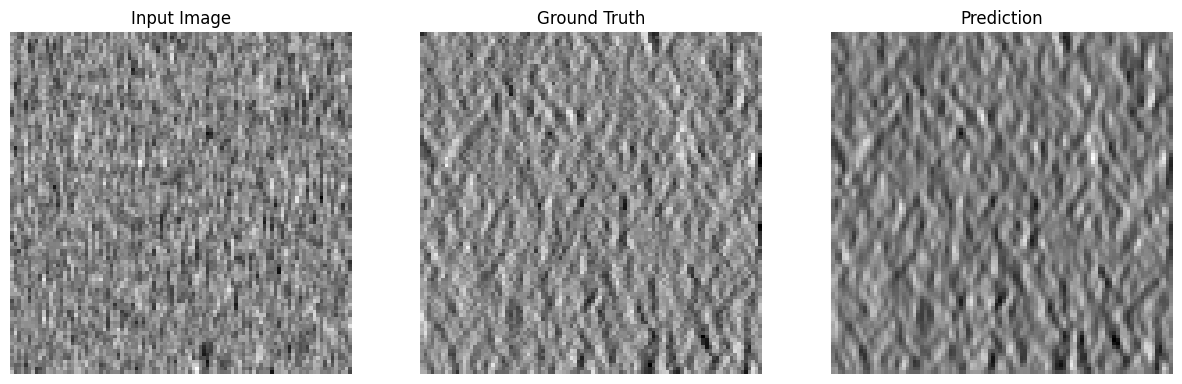

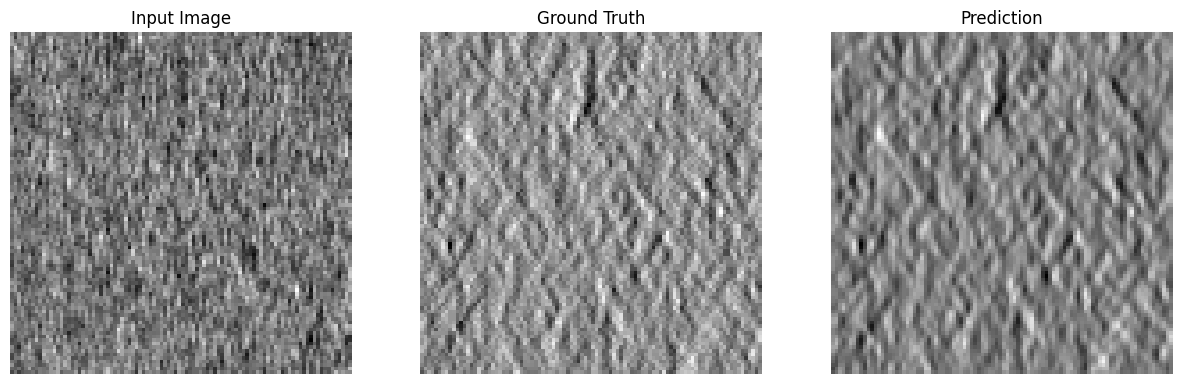

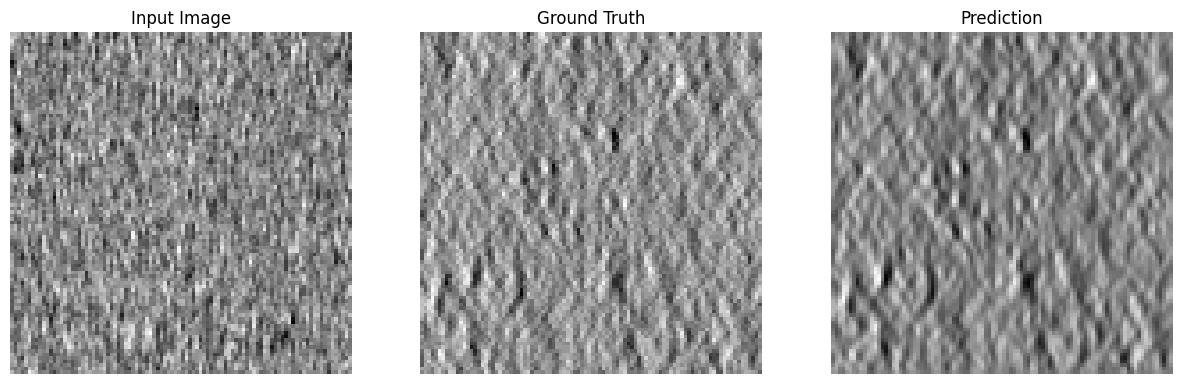

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 최적의 모델 불러오기
def load_best_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def get_predictions(model, data_loader, device, num_images=5):
    model.eval()
    images, labels, preds = [], [], []
    
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc='Visualizing'):
            image = batch_data['image'].to(device)
            label = batch_data['label'].to(device)
            
            pred = model(image)
            
            images.append(image.cpu().numpy())
            labels.append(label.cpu().numpy())
            preds.append(pred.cpu().numpy())
            
            if len(images) >= num_images:
                break
    return images, labels, preds
# 예측 결과와 실제 라벨 시각화 함수
def visualize_predictions(model, val_loader, device, num_images=5):
    images, labels, preds = get_predictions(model, val_loader, device, num_images)
    
    # 시각화
    for i in range(num_images):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(images[i][0, 0, :, :, 48], cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        axes[1].imshow(labels[i][0, 0, :, 48], cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        
        # 예측 값 확인
        # print("Unique values in predictions:", np.unique(preds[i]))
        
        # 데이터 범위 설정
        axes[2].imshow(preds[i][0, 0, :, 48], cmap='gray')
        axes[2].set_title('Prediction')
        axes[2].axis('off')
        
        plt.show()
        
# 모델 학습 후 최적의 모델 불러오기 및 시각화
model = model  # 모델 정의
val_loader = val_loader  # 검증 데이터 로더
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = os.path.join(checkpoint_dir, 'best_model.pt')  # 저장된 최적의 모델 경로

# 최적의 모델 불러오기
if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

# 예측 결과와 실제 라벨 시각화
visualize_predictions(model, val_loader, device, num_images=3)

Visualizing:  20%|██        | 2/10 [00:00<00:00, 34.35it/s]


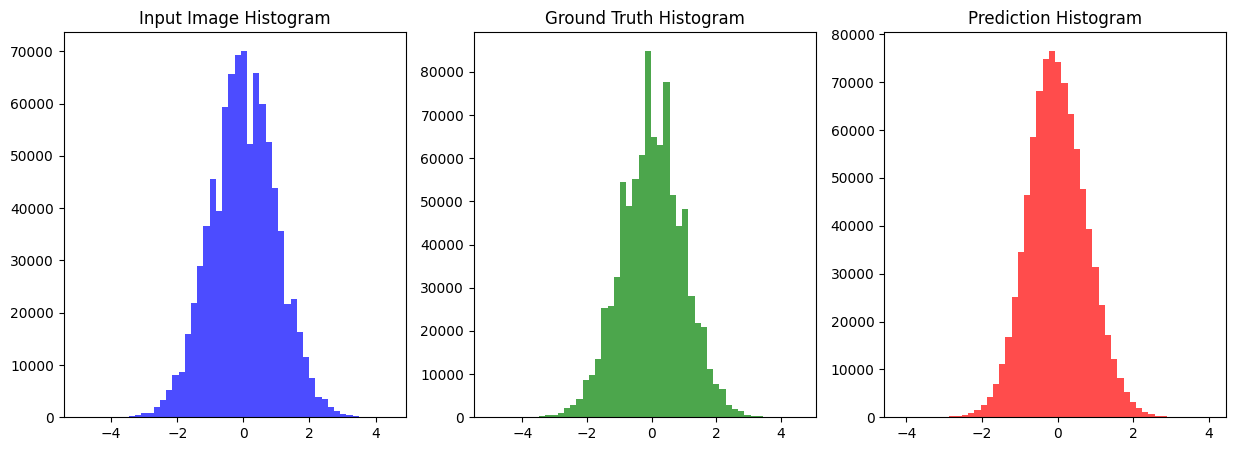

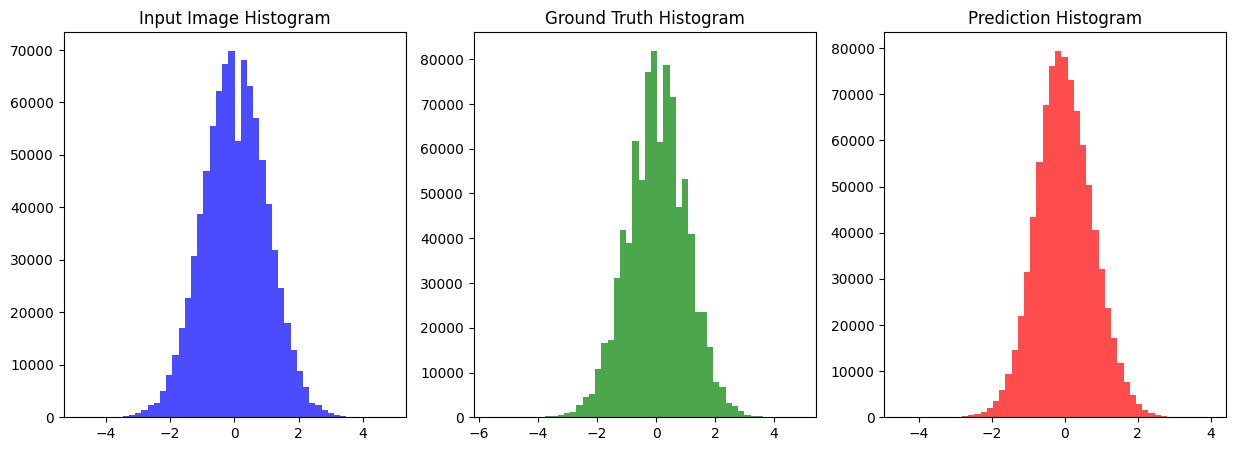

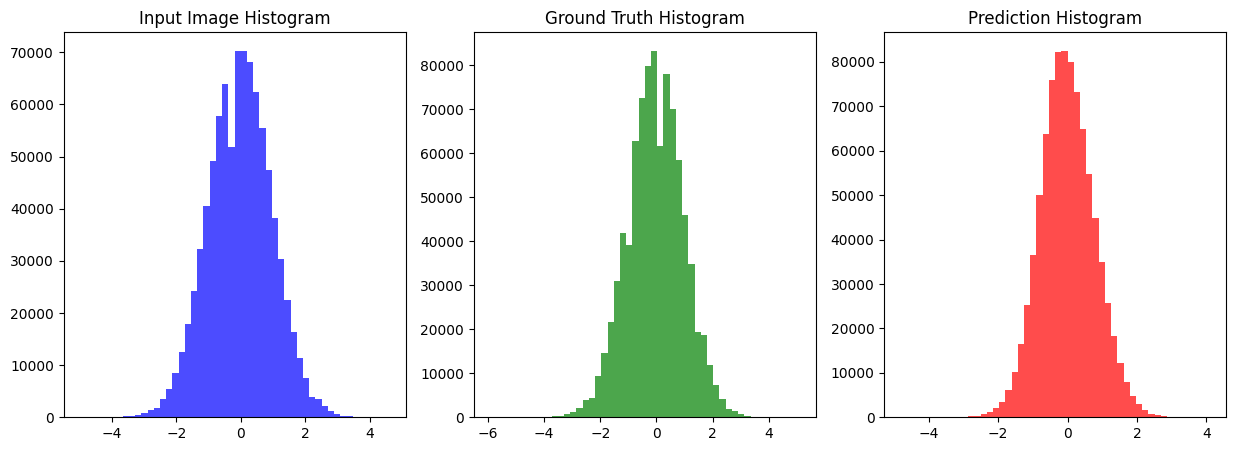

In [13]:
from scipy.stats import wasserstein_distance

def plot_histograms(images, labels, preds, num_images=3):
    for i in range(num_images):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].hist(images[i].flatten(), bins=50, color='blue', alpha=0.7)
        axes[0].set_title('Input Image Histogram')
        
        axes[1].hist(labels[i].flatten(), bins=50, color='green', alpha=0.7)
        axes[1].set_title('Ground Truth Histogram')
        
        axes[2].hist(preds[i].flatten(), bins=50, color='red', alpha=0.7)
        axes[2].set_title('Prediction Histogram')
        
        plt.show()

# 예측 결과와 실제 라벨 시각화 및 히스토그램 시각화
images, labels, preds = get_predictions(model, val_loader, device, num_images=3)
plot_histograms(images, labels, preds, num_images=3)


In [14]:
def calculate_histogram_similarity(images, labels, preds, num_images=3):
    for i in range(num_images):
        image_hist, _ = np.histogram(images[i].flatten(), bins=50, density=True)
        label_hist, _ = np.histogram(labels[i].flatten(), bins=50, density=True)
        pred_hist, _ = np.histogram(preds[i].flatten(), bins=50, density=True)
        
        image_label_similarity = wasserstein_distance(image_hist, label_hist)
        image_pred_similarity = wasserstein_distance(image_hist, pred_hist)
        label_pred_similarity = wasserstein_distance(label_hist, pred_hist)
        
        print(f"Image {i+1} - Image vs Label Similarity: {image_label_similarity:.4f}")
        print(f"Image {i+1} - Label vs Prediction Similarity: {label_pred_similarity:.4f}")

calculate_histogram_similarity(images, labels, preds, num_images=3)

Image 1 - Image vs Label Similarity: 0.0099
Image 1 - Label vs Prediction Similarity: 0.0201
Image 2 - Image vs Label Similarity: 0.0122
Image 2 - Label vs Prediction Similarity: 0.0229
Image 3 - Image vs Label Similarity: 0.0138
Image 3 - Label vs Prediction Similarity: 0.0214


In [15]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)